# Mini-Project for Fundamentals of Machine Learning Course

In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.


## 1. Prerequisite

This section provides some basic steps for accessing and visualizing the dataset.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from tqdm import tqdm, trange
from lazypredict.Supervised import LazyClassifier

In [2]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data["emotion"])))

    for i, row in tqdm(enumerate(data.index)):
        image = np.fromstring(data.loc[row, "pixels"], dtype=int, sep=" ")
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [3]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr = plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr = axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap="gray")
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

In [4]:
## load dataset here
df = pd.read_csv("../data/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The `emotion` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.


In [5]:
## parsing data here
images, labels = parse_data(df)

35887it [00:03, 9979.92it/s] 


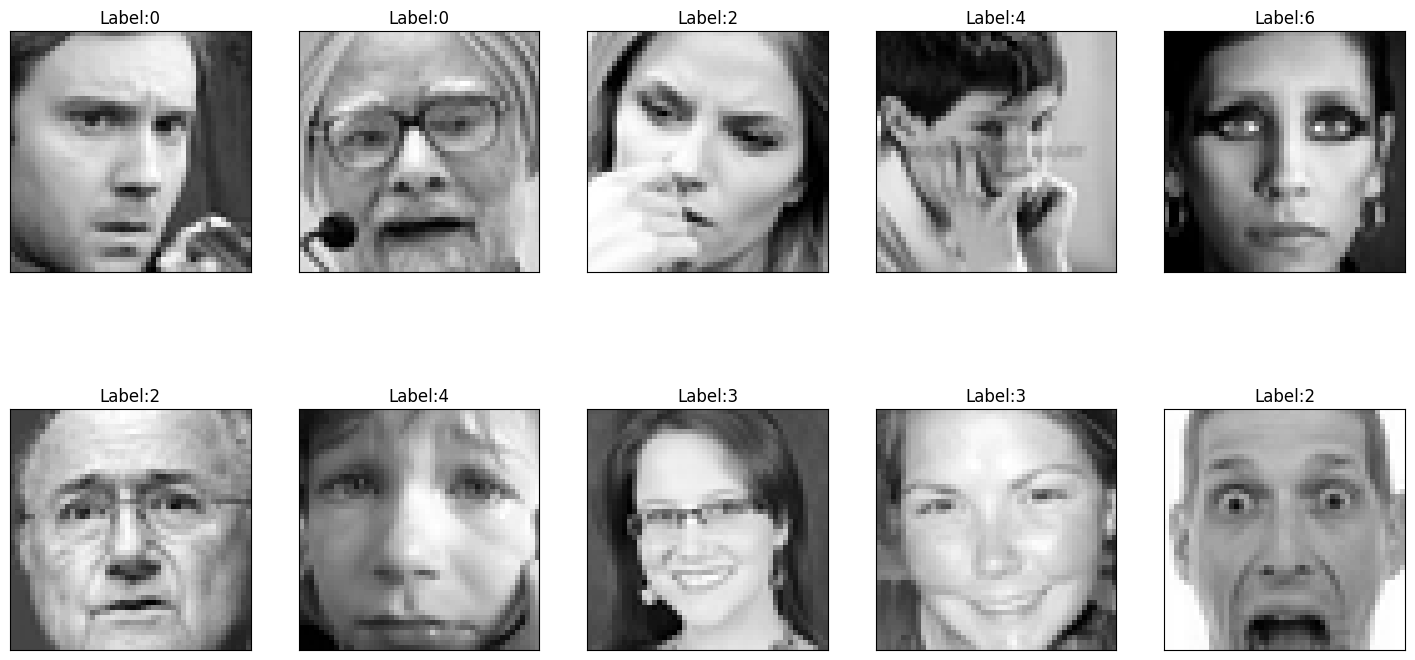

In [6]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.


Question 1: Can you visualize the data projected onto two principal components? (2 points)


In [7]:
raw_images = images.copy()
images = images.reshape(labels.shape[0], -1)
normalized_images = images / 255.0

In [8]:
pca_2_components = PCA(n_components=2)
pca_images = pca_2_components.fit_transform(normalized_images)
pca_images.shape

(35887, 2)

In [9]:
def reconstructing_image(image: np.ndarray[float], pca: PCA) -> np.ndarray[int]:
    if not isinstance(pca, PCA):
        raise TypeError("pca must be an instance of sklearn.decomposition.PCA")
    reconstructed_images = pca.inverse_transform(image)
    reconstructed_images = (reconstructed_images * 255).astype(np.uint8)
    reconstructed_images = reconstructed_images.reshape(48, 48)
    return reconstructed_images

In [10]:
def plot_compare_pca_images(
    raw: np.ndarray[int],
    transformed: np.ndarray[float],
    labels: np.ndarray,
    pca: PCA,
    n_images: int = 2,
) -> None:
    
    _, axes = plt.subplots(nrows=2, ncols=n_images, figsize=(9, 9 * n_images))
    for idx, label in enumerate(labels):
        if idx >= n_images:
            break
        
        idx_random = np.random.randint(0, len(labels))
        
        # Show raw images
        axes[idx][0].imshow(raw[idx_random], cmap="gray")
        axes[idx][0].set_xticks([])
        axes[idx][0].set_yticks([])
        axes[idx][0].set_title(f"Raw|Label:{label}")

        # Show transformed images
        axes[idx][1].imshow(
            reconstructing_image(transformed[idx_random], pca=pca), cmap="gray"
        )
        axes[idx][1].set_xticks([])
        axes[idx][1].set_yticks([])
        axes[idx][1].set_title(f"Transformed|Label:{label}")
    plt.tight_layout()
    plt.show()

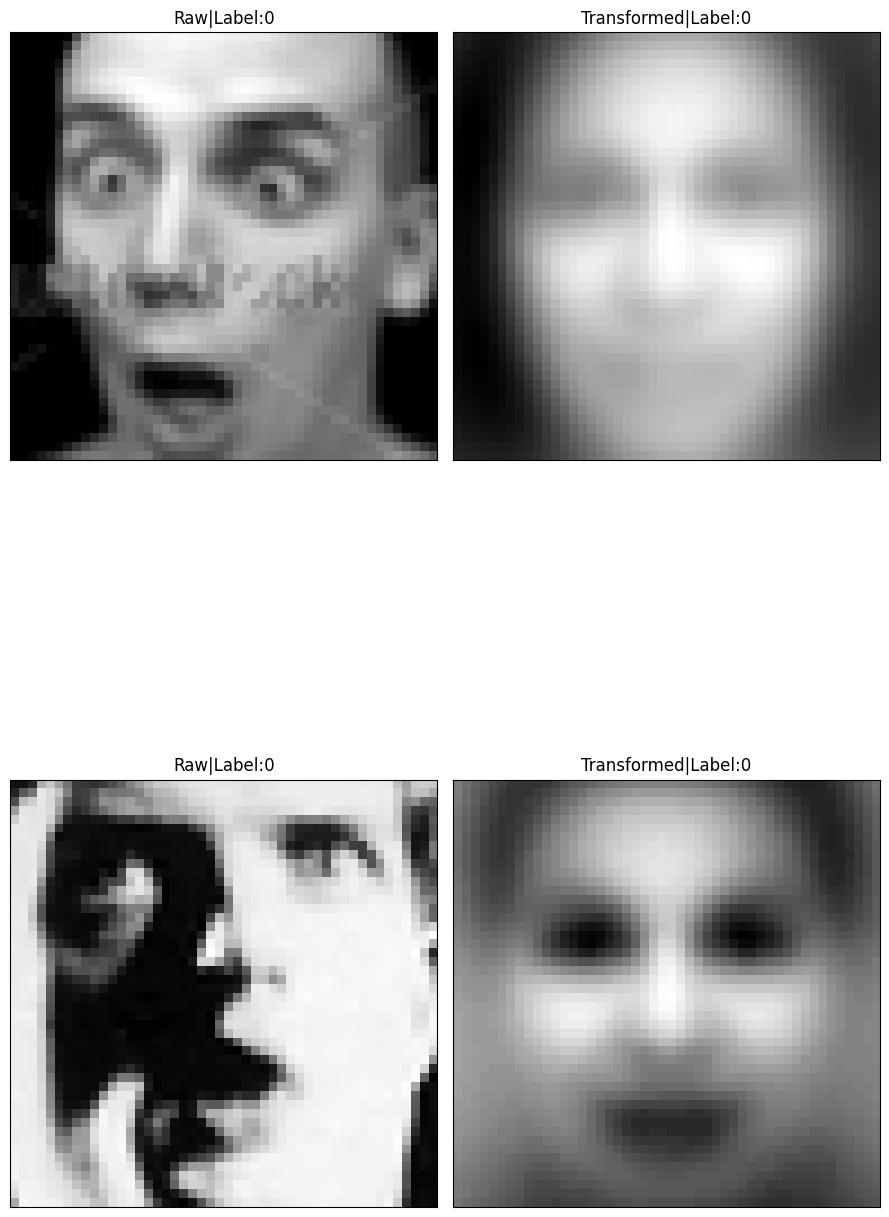

In [11]:
plot_compare_pca_images(raw_images, pca_images, labels, pca_2_components)

Question 2: How to determine the optimal number of principal components using `pca.explained_variance_`? Explain your selection process. (2 points)


In [12]:
pca_full = PCA()
pca_full.fit(normalized_images)

PCA()

In [13]:
## determine the optimal number of PCs here
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

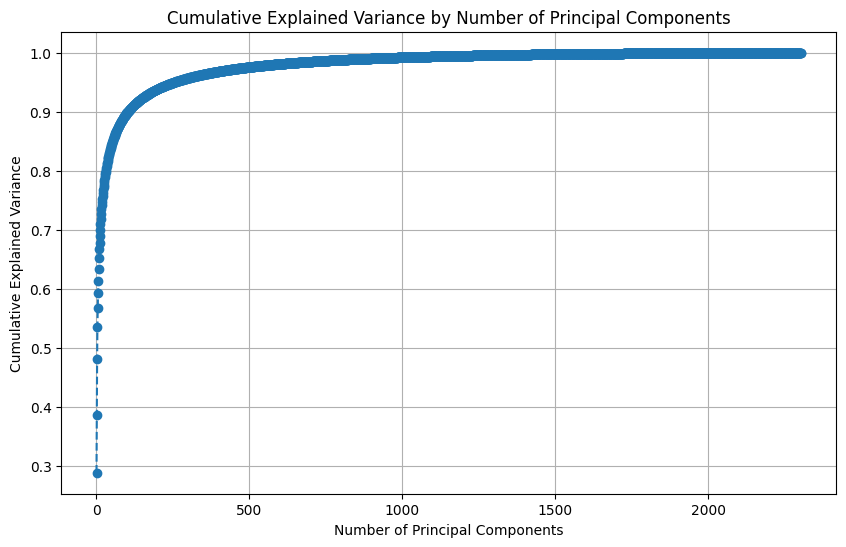

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(cumulative_explained_variance) + 1),
    cumulative_explained_variance,
    marker="o",
    linestyle="--",
)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by Number of Principal Components")
plt.grid(True)
plt.show()

## 3. Image Classification


The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using `GridSearchCV` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html


In [15]:
transformed_data = PCA(n_components=1000).fit_transform(normalized_images)

In [16]:
## splitting data into train/val/test subsets here
X_train, X_test, y_train, y_test = train_test_split(transformed_data, labels, test_size=0.2)

In [17]:
clf = LazyClassifier(verbose=0, custom_metric=None)
scores, predictions = clf.fit(X_train, X_test, y_train, y_test)

 39%|███▊      | 12/31 [14:27<05:59, 18.90s/it]  

In [ ]:
display(scores)

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)


In [ ]:
## visualize the confusion matrices and classification reports here